In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader  
from skimage import io
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from zipfile import ZipFile
import os
from os import path
import shutil
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
url='/content/drive/MyDrive/Dataset/data/'

In [6]:
dataset_2 = url + 'Dataset_2.zip'
with ZipFile(dataset_2, 'r') as zip:
  zip.extractall()

In [7]:
train_csv2  = pd.read_csv('/content/Dataset_2/verification_train.csv')
test_csv2 = pd.read_csv('/content/Dataset_2/verification_test.csv')

In [8]:
print(train_csv2.shape)
train_csv2.head()

(60000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [9]:
print(test_csv2.shape)
test_csv2.head()

(10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [ ]:

class second_Dataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.data_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.data_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
train_set = second_Dataset(train_csv2, transform=transforms.Compose([transforms.ToTensor()]))
test_set = second_Dataset(test_csv2, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [ ]:
print(len(train_set))
print(len(test_set))

60000
10000


In [ ]:
# Hyperparameters
batch_size = 142
num_iters = 20000
input_dim = 28*28
num_hidden = 220
output_dim = 10

learning_rate = 0.001


num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



47


In [ ]:

'''
MAKING DATASET ITERABLE
'''


train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False)






In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()

       #First Hidden Layer
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        #2nd Hidden Layer
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)

         #3rd Hidden Layer
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

         #4th Hidden Layer
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()

         

  
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=220, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=220, out_features=220, bias=True)
  (relu_2): Softmax(dim=0)
  (linear_3): Linear(in_features=220, out_features=220, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=220, out_features=220, bias=True)
  (relu_4): ReLU()
  (linear_out): Linear(in_features=220, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Iteration: 500. Loss: 1.4307887554168701. Accuracy: 49.49
Epoch:  3
Iteration: 1000. Loss: 1.320658802986145. Accuracy: 51.72
Epoch:  4
Iteration: 1500. Loss: 1.2557690143585205. Accuracy: 52.9
Epoch:  5
Iteration: 2000. Loss: 1.172056794166565. Accuracy: 53.32
Epoch:  6
Iteration: 2500. Loss: 1.4062455892562866. Accuracy: 52.51
Epoch:  7
Epoch:  8
Iteration: 3000. Loss: 1.1235730648040771. Accuracy: 55.93
Epoch:  9
Iteration: 3500. Loss: 1.2601675987243652. Accuracy: 54.34
Epoch:  10
Iteration: 4000. Loss: 1.1981310844421387. Accuracy: 56.33
Epoch:  11
Iteration: 4500. Loss: 1.2764102220535278. Accuracy: 54.78
Epoch:  12
Iteration: 5000. Loss: 1.1865980625152588. Accuracy: 54.37
Epoch:  13
Epoch:  14
Iteration: 5500. Loss: 1.1785286664962769. Accuracy: 53.0
Epoch:  15
Iteration: 6000. Loss: 1.1760531663894653. Accuracy: 54.07
Epoch:  16
Iteration: 6500. Loss: 1.0892916917800903. Accuracy: 54.62
Epoch:  17
Iteration: 7000. Loss: 1.1716344356536865. Accuracy: 53.15
E

[1.4307887554168701, 1.320658802986145, 1.2557690143585205, 1.172056794166565, 1.4062455892562866, 1.1235730648040771, 1.2601675987243652, 1.1981310844421387, 1.2764102220535278, 1.1865980625152588, 1.1785286664962769, 1.1760531663894653, 1.0892916917800903, 1.1716344356536865, 1.3870664834976196, 0.9917847514152527, 1.2270749807357788, 1.0420838594436646, 1.1618071794509888, 1.1819233894348145, 1.1969797611236572, 1.1839810609817505, 1.0945751667022705, 1.1670831441879272, 1.1567695140838623, 1.059684157371521, 1.0015251636505127, 1.0316355228424072, 1.1652467250823975, 1.1997668743133545, 1.1057640314102173, 1.1367977857589722, 1.2111979722976685, 1.2309627532958984, 1.0894240140914917, 1.1140210628509521, 1.2087372541427612, 1.1554601192474365, 1.0450860261917114]


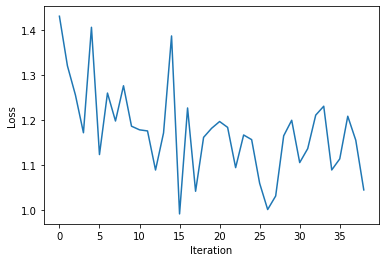

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()